In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
from itertools import groupby
import matplotlib.pyplot as plt
import numpy as np
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.models import (
    Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool,
    BoxZoomTool, WheelZoomTool, PanTool
)
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes, NodesOnly
from bokeh.palettes import Spectral4
from google.cloud import bigquery

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
flatten = lambda list_of_lists: [val for sublist in list_of_lists for val in sublist]

In [5]:
data_path = '../data'
pagerank_filename = 'crossref-works-summary-with-pagerank-sorted-by-pagerank.tsv.gz'

In [6]:
df = pd.read_csv(
    os.path.join(data_path, pagerank_filename),
    sep='\t',
    nrows=1000 * 1000, # limit to the top 1M manuscripts, according to the pagerank (due to the memory),
    index_col='doi'
)

In [7]:
df['created_dt'] = pd.to_datetime(df['created'])

In [8]:
# fix the data
df['first_subject_area'] = df['subject_areas'].map(lambda x: x.split('|')[0] if not pd.isnull(x) else None)

In [9]:
df.dtypes

incoming                        int64
outgoing                        int64
pagerank                      float64
title                          object
reference_count               float64
referenced_by_count           float64
created                        object
type                           object
publisher                      object
container_title                object
author_count                  float64
fist_subject_area             float64
subject_areas                  object
provenance                     object
created_dt             datetime64[ns]
first_subject_area             object
dtype: object

In [10]:
df.head()

,incoming,outgoing,pagerank,title,reference_count,referenced_by_count,created,type,publisher,container_title,author_count,fist_subject_area,subject_areas,provenance,created_dt,first_subject_area
doi,,,,,,,,,,,,,,,,
10.1038/227680a0,35500,3,154.13618,Cleavage of Structural Proteins during the Ass...,22.0,129131.0,2005-08-01T18:25:18Z,journal-article,Springer Nature,Nature,1.0,NaN,Multidisciplinary,crossref-works-page-92943-offset-92943000.json,2005-08-01 18:25:18,Multidisciplinary
10.1016/0003-2697(76)90527-3,34913,0,149.18823,A rapid and sensitive method for the quantitat...,24.0,113788.0,2004-12-08T18:24:04Z,journal-article,Elsevier BV,Analytical Biochemistry,1.0,NaN,Biophysics|Cell Biology|Biochemistry|Molecular...,crossref-works-page-93069-offset-93069000.json,2004-12-08 18:24:04,Biophysics
10.1107/s0108767307043930,26464,0,145.72604,A short history ofSHELX,60.0,52231.0,2007-12-21T14:12:50Z,journal-article,International Union of Crystallography (IUCr),Acta Crystallographica Section A Foundations o...,1.0,NaN,NaN,crossref-works-page-93063-offset-93063000.json,2007-12-21 14:12:50,None
10.1006/meth.2001.1262,23043,0,123.47473,Analysis of Relative Gene Expression Data Usin...,11.0,45463.0,2002-10-06T19:30:44Z,journal-article,Elsevier BV,Methods,2.0,NaN,"General Biochemistry, Genetics and Molecular B...",crossref-works-page-93065-offset-93065000.json,2002-10-06 19:30:44,"General Biochemistry, Genetics and Molecular B..."
10.1006/abio.1976.9999,7063,0,110.61359,A Rapid and Sensitive Method for the Quantitat...,0.0,10938.0,2003-01-09T12:12:55Z,journal-article,Elsevier BV,Analytical Biochemistry,1.0,NaN,Biophysics|Cell Biology|Biochemistry|Molecular...,crossref-works-page-90347-offset-90347000.json,2003-01-09 12:12:55,Biophysics


In [11]:
df.shape

(1000000, 16)

In [12]:
journal_articles_df = df[df['type'] == 'journal-article']

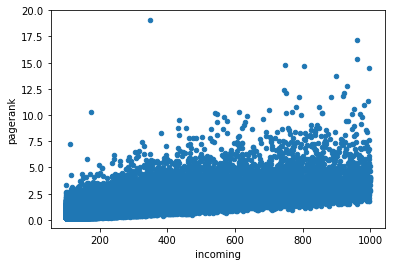

In [13]:
journal_articles_cited_between_100_to_1000_df = journal_articles_df[
    (journal_articles_df['incoming'] >= 100) & (journal_articles_df['incoming'] <= 1000)
]
journal_articles_cited_between_100_to_1000_df.plot(x='incoming', y='pagerank', kind='scatter')

In [14]:
journal_articles_cited_between_100_to_1000_df.sort_values('pagerank', ascending=False).head(10)

,incoming,outgoing,pagerank,title,reference_count,referenced_by_count,created,type,publisher,container_title,author_count,fist_subject_area,subject_areas,provenance,created_dt,first_subject_area
doi,,,,,,,,,,,,,,,,
10.1080/00028896209343211,348,2,19.032753,Range-Finding Toxicity Data: List VI,11.0,476.0,2011-09-29T11:20:17Z,journal-article,Informa UK Limited,American Industrial Hygiene Association Journal,5.0,NaN,"Public Health, Environmental and Occupational ...",crossref-works-page-82682-offset-82682000.json,2011-09-29 11:20:17,"Public Health, Environmental and Occupational ..."
10.1001/archsurg.1992.01420040034005,962,0,17.157185,Technical Details of Intraoperative Lymphatic ...,0.0,2134.0,2011-11-30T22:39:36Z,journal-article,American Medical Association (AMA),Archives of Surgery,1.0,NaN,Surgery,crossref-works-page-91582-offset-91582000.json,2011-11-30 22:39:36,Surgery
10.1002/(sici)1097-4571(199009)41:6<391::aid-asi1>3.0.co;2-9,960,0,15.299405,Indexing by latent semantic analysis,0.0,2780.0,2004-11-23T10:21:26Z,journal-article,Wiley-Blackwell,Journal of the American Society for Informatio...,5.0,NaN,General Engineering,crossref-works-page-92497-offset-92497000.json,2004-11-23 10:21:26,General Engineering
10.1042/bj0610629,748,0,14.783077,Zone electrophoresis in starch gels: group var...,0.0,1538.0,2015-08-10T18:44:27Z,journal-article,Portland Press Ltd.,Biochemical Journal,1.0,NaN,Cell Biology|Biochemistry|Molecular Biology,crossref-works-page-92601-offset-92601000.json,2015-08-10 18:44:27,Cell Biology
10.1159/000228215,805,0,14.678371,Une micro-méthode de l’immuno-électrophorèse,0.0,2339.0,2009-07-07T14:59:48Z,journal-article,S. Karger AG,International Archives of Allergy and Immunology,1.0,NaN,Immunology|Immunology and Allergy|General Medi...,crossref-works-page-91225-offset-91225000.json,2009-07-07 14:59:48,Immunology
10.1093/comjnl/6.2.163,997,0,14.472257,A Rapidly Convergent Descent Method for Minimi...,0.0,2626.0,2012-11-19T22:22:54Z,journal-article,Oxford University Press (OUP),The Computer Journal,2.0,NaN,General Computer Science,crossref-works-page-92553-offset-92553000.json,2012-11-19 22:22:54,General Computer Science
10.1016/0003-2697(60)90025-7,898,0,13.723287,A simple efficient liquid scintillator for cou...,13.0,4753.0,2004-12-08T18:14:58Z,journal-article,Elsevier BV,Analytical Biochemistry,1.0,NaN,Biophysics|Cell Biology|Biochemistry|Molecular...,crossref-works-page-89818-offset-89818000.json,2004-12-08 18:14:58,Biophysics
10.6028/jres.057.026,932,0,12.794434,Variation of peak temperature with heating rat...,0.0,1966.0,2012-09-07T17:16:51Z,journal-article,National Institute of Standards and Technology...,Journal of Research of the National Bureau of ...,1.0,NaN,NaN,crossref-works-page-92707-offset-92707000.json,2012-09-07 17:16:51,None
10.1002/j.1538-7305.1969.tb01198.x,745,0,12.406329,Coupled Wave Theory for Thick Hologram Gratings,38.0,2863.0,2013-07-29T17:11:20Z,journal-article,Institute of Electrical and Electronics Engine...,Bell System Technical Journal,1.0,NaN,General Engineering,crossref-works-page-92873-offset-92873000.json,2013-07-29 17:11:20,General Engineering


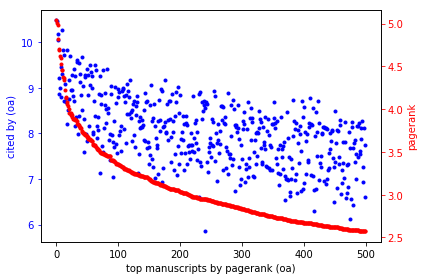

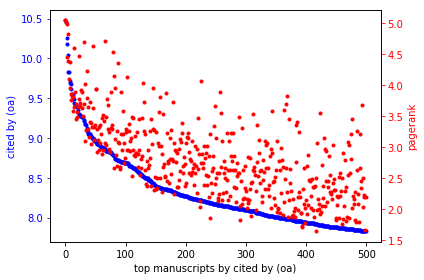

In [15]:
def plot_cited_vs_pagerank(title, df_sub, ref_count_field):
    fig, ax1 = plt.subplots()
    t = range(len(df_sub))
    mad = lambda x: np.fabs(x - x.mean()).mean()
    s1 = pd.np.log(df_sub[ref_count_field].values)
    ax1.plot(t, s1, 'b.')
    ax1.set_xlabel(title)
    ax1.set_ylabel('cited by (oa)', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    s2 = pd.np.log(df_sub.pagerank.values)
    ax2.plot(t, s2, 'r.')
    ax2.set_ylabel('pagerank', color='r')
    ax2.tick_params('y', colors='r')

    fig.tight_layout()

top_count = 500
plot_cited_vs_pagerank(
    'top manuscripts by pagerank (oa)',
    df[:top_count],
    'incoming'
)
plot_cited_vs_pagerank(
    'top manuscripts by cited by (oa)',
    df.sort_values('incoming', ascending=False)[:top_count].reset_index(),
    'incoming'
)
plt.show()

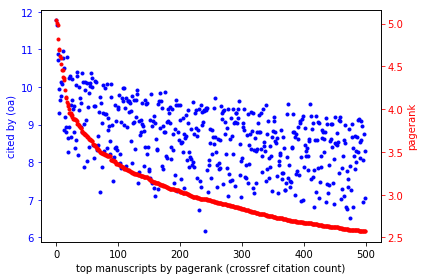

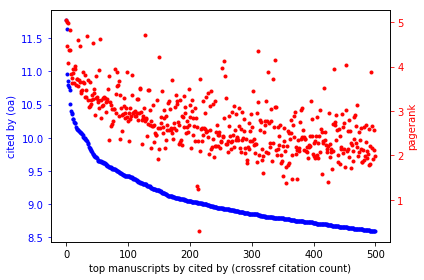

In [16]:
plot_cited_vs_pagerank(
    'top manuscripts by pagerank (crossref citation count)',
    df[:top_count],
    'referenced_by_count'
)
plot_cited_vs_pagerank(
    'top manuscripts by cited by (crossref citation count)',
    df.sort_values('referenced_by_count', ascending=False)[:top_count].reset_index(),
    'referenced_by_count'
)
plt.show()

In [17]:
def with_ranking_change(df_sub, total):
    original_position = df_sub['position_by_pagerank'].values
    new_position = pd.Series(range(len(df_sub))) # sorted by citation count
    df_result = df_sub.reset_index()
    df_result['position'] = new_position
    df_result['change'] = new_position - original_position
    df_result['abs_change'] = pd.np.abs(df_result.change)
    df_result['pchange'] = df_result['change'] / total
    df_result['abs_pchange'] = df_result['abs_change'] / total
    return df_result

def get_movers_pagerank_vs_incoming(df_sub, total):
    return with_ranking_change(
        df_sub
        .dropna(subset=['title'])
        .sort_values('incoming', ascending=False),
        total=total
    ).rename(columns={
        'position': 'position_by_ref_count'
    }).sort_values('abs_pchange', ascending=False)\
    [['doi', 'change', 'pchange', 'abs_pchange', 'position_by_pagerank', 'position_by_ref_count', 'incoming', 'referenced_by_count', 'pagerank', 'title']]

def get_top_movers_pagerank_vs_incoming(df_sub, total):
    return get_movers_pagerank_vs_incoming(df_sub, total)[:top_count]

In [18]:
# assumed to be sorted by pagerank
df['position_by_pagerank'] = range(len(df))

In [19]:
# oa referenced by 1000 or more
top_movers_1000_plus = get_top_movers_pagerank_vs_incoming(
    df[df['incoming'] > 1000],
    total=len(df)
).set_index('doi')

top_movers_1000_plus.head(10)

,change,pchange,abs_pchange,position_by_pagerank,position_by_ref_count,incoming,referenced_by_count,pagerank,title
doi,,,,,,,,,
10.1038/nature14133,-28711,-0.028711,0.028711,31657,2946,1017,1632.0,1.354491,Compositional engineering of perovskite materi...
10.1038/ncb1722,-25924,-0.025924,0.025924,28885,2961,1015,1648.0,1.424455,The miR-200 family and miR-205 regulate epithe...
10.1021/ja201269b,-20947,-0.020947,0.020947,23670,2723,1056,1794.0,1.597160,MoS2Nanoparticles Grown on Graphene: An Advanc...
10.1038/nmat4014,-20740,-0.020740,0.020740,23226,2486,1106,1763.0,1.613849,Solvent engineering for high-performance inorg...
10.1158/0008-5472.can-05-1783,-18762,-0.018762,0.018762,21612,2850,1032,1859.0,1.678232,MicroRNA Gene Expression Deregulation in Human...
10.1103/physrevb.83.205101,-17028,-0.017028,0.017028,19631,2603,1079,1243.0,1.766215,Topological semimetal and Fermi-arc surface st...
10.1039/c1cs15078b,-15723,-0.015723,0.015723,18352,2629,1073,1808.0,1.832675,Graphene-based composites
10.1038/nature08975,-15572,-0.015572,0.015572,18305,2733,1055,1599.0,1.835783,Long non-coding RNA HOTAIR reprograms chromati...
10.1103/physrevb.78.195424,-15516,-0.015516,0.015516,18075,2559,1088,1399.0,1.849113,Topological field theory of time-reversal inva...


In [20]:
# oa referenced by 100 or more
top_movers_100_plus = get_top_movers_pagerank_vs_incoming(
    df[df['incoming'] > 100],
    total=len(df)
).set_index('doi')

top_movers_100_plus.head(10)

,change,pchange,abs_pchange,position_by_pagerank,position_by_ref_count,incoming,referenced_by_count,pagerank,title
doi,,,,,,,,,
10.1002/anie.201206854,-916921,-0.916921,0.916921,995115,78194,180,276.0,0.199612,A Superior Low-Cost Cathode for a Na-Ion Battery
10.1021/ja808329f,-911085,-0.911085,0.911085,982763,71678,189,337.0,0.201070,Activation of Carbon Nitride Solids by Protona...
10.1002/anie.201310877,-909850,-0.909850,0.909850,988297,78447,180,189.0,0.200412,"A Simple 3,4-Ethylenedioxythiophene Based Hole..."
10.1038/nchem.2324,-902276,-0.902276,0.902276,983156,80880,177,260.0,0.201024,Improved performance and stability of perovski...
10.1039/c1ee01496j,-898553,-0.898553,0.898553,967699,69146,193,336.0,0.202883,All-carbon-nanofiber electrodes for high-energ...
10.1002/ange.200902458,-895824,-0.895824,0.895824,993984,98160,159,187.0,0.199742,Rutheniumkatalysierte regioselektive direkte A...
10.1128/mcb.01977-07,-891589,-0.891589,0.891589,982965,91376,166,280.0,0.201046,MicroRNAs in the miR-106b Family Regulate p21/...
10.1074/jbc.m705325200,-890132,-0.890132,0.890132,978486,88354,169,308.0,0.201585,The Energy Sensor AMP-activated Protein Kinase...
10.1073/pnas.0808830105,-889839,-0.889839,0.889839,988936,99097,158,325.0,0.200334,MicroRNA-directed transcriptional gene silenci...


In [21]:
# top 1000
top_movers_1000 = get_top_movers_pagerank_vs_incoming(
    df[:1000],
    total=len(df)
).set_index('doi')
top_movers_1000.head(10)

,change,pchange,abs_pchange,position_by_pagerank,position_by_ref_count,incoming,referenced_by_count,pagerank,title
doi,,,,,,,,,
10.1038/nprot.2008.73,-753,-0.000753,0.000753,986,233,3608,6202.0,8.958149,Analyzing real-time PCR data by the comparativ...
10.1080/00028896209343211,749,0.000749,0.000749,240,989,348,476.0,19.032753,Range-Finding Toxicity Data: List VI
10.1016/j.cell.2009.01.002,-732,-0.000732,0.000732,908,176,4091,6976.0,9.448090,MicroRNAs: Target Recognition and Regulatory F...
10.1007/978-1-349-03521-2,706,0.000706,0.000706,91,797,1134,1815.0,30.009897,Graph Theory with Applications
10.1038/nmeth.f.303,-706,-0.000706,0.000706,863,157,4313,6138.0,9.688854,QIIME allows analysis of high-throughput commu...
10.1007/978-3-642-88458-0,696,0.000696,0.000696,230,926,732,847.0,19.284943,The Systematic Identification of Flavonoids
10.1007/978-3-642-64981-3,695,0.000695,0.000695,71,766,1242,1365.0,33.249134,Endliche Gruppen I
10.1103/physrevb.49.14251,-692,-0.000692,0.000692,955,263,3414,7716.0,9.141130,Ab initiomolecular-dynamics simulation of the ...
10.1063/1.438955,-678,-0.000678,0.000678,999,321,3007,7372.0,8.901431,Self‐consistent molecular orbital methods. XX....


In [22]:
client = bigquery.Client()

TIMEOUT_MS = 100 * 1000
DEFAULT_LIMIT = 100000000

# Get data from BigQuery as it's a bit large to keep all in memory
def get_citing_dois_as_flat_list(cited_dois, limit=DEFAULT_LIMIT):
    PAGE_SIZE = 1000
    client = bigquery.Client()
    q =\
'''
#standardSQL
SELECT cited_doi, citing_doi
FROM `elife-ml.crossref_works_citations.crossref_works_citations`
WHERE cited_doi IN UNNEST(@cited_dois)
LIMIT {}
'''.format(limit)
    query = client.run_sync_query(q, query_parameters=(
        bigquery.ArrayQueryParameter('cited_dois', 'STRING', cited_dois),
    ))
    query.timeout_ms = TIMEOUT_MS
    query.max_results = PAGE_SIZE
    query.run()
    assert query.complete
    rows = list(tqdm(query.fetch_data()))
    print('rows:', len(rows))
    return rows

def get_citing_dois_as_map(cited_dois, limit=DEFAULT_LIMIT):
    key = lambda row: row[0]
    rows = get_citing_dois_as_flat_list(cited_dois, limit=limit)
    return {
        k: [x[1] for x in v]
        for k, v in groupby(sorted(rows, key=key), key=key)
    }

def get_citing_dois_as_nested_list(cited_dois, limit=DEFAULT_LIMIT):
    m = get_citing_dois_as_map(cited_dois, limit=limit)
    return [
        m.get(cited_doi)
        for cited_doi in cited_dois
    ]

In [23]:
# get cited by dois from bigquery
cited_dois = top_movers_1000.index.values[:100]
citing_dois_map = get_citing_dois_as_map(cited_dois)
len(citing_dois_map)

166199it [00:07, 23087.08it/s]


rows: 166199


98

In [24]:
all_movers = get_movers_pagerank_vs_incoming(
    df,
    total=len(df)
).set_index('doi')
print(len(all_movers))
all_movers.head()

991663


,change,pchange,abs_pchange,position_by_pagerank,position_by_ref_count,incoming,referenced_by_count,pagerank,title
doi,,,,,,,,,
10.13182/nt80-a17075,957509,0.957509,0.957509,32594,990103,2,0.0,1.333333,Reply to “Comments on Thermal-Neutron Flux Dep...
10.2514/3.28402,955186,0.955186,0.955186,22439,977625,4,4.0,1.644323,Preflight analysis of target errors of a space...
10.13182/nt07-a3891,948453,0.948453,0.948453,41673,990126,2,0.0,1.166666,Study on Leak Rate of Gas Medium in Leak-Befor...
10.2514/1.16890,947537,0.947537,0.947537,43251,990788,2,3.0,1.142857,Drag Reductions Possible with Aircraft Employi...
10.3406/phlou.1972.5651,946826,0.946826,0.946826,32896,979722,4,4.0,1.326517,La métaphore et le problème central de l'hermé...


In [25]:
df_citing_dois = pd.DataFrame(
    flatten([
        [
            [cited_doi, citing_doi]
            for citing_doi in citing_dois_map.get(cited_doi, [])
        ] for cited_doi in cited_dois
    ]),
    columns=['cited_doi', 'citing_doi']
)
df_citing_dois.head()

,cited_doi,citing_doi
0,10.1038/nprot.2008.73,10.1002/0471140856.tx2009s64
1,10.1038/nprot.2008.73,10.1002/0471142905.hg0721s80
2,10.1038/nprot.2008.73,10.1002/1873-3468.12435
3,10.1038/nprot.2008.73,10.1002/1873-3468.12453
4,10.1038/nprot.2008.73,10.1002/9780470559277.ch110204


In [26]:
df_citing_dois_stats = all_movers.merge(
    df_citing_dois,
    left_index=True,
    right_on='citing_doi'
).groupby('cited_doi').mean()
df_citing_dois_stats.columns = df_citing_dois_stats.columns.map(lambda x: 'citing_mean_' + str(x))
df_citing_dois_stats.head()

,citing_mean_change,citing_mean_pchange,citing_mean_abs_pchange,citing_mean_position_by_pagerank,citing_mean_position_by_ref_count,citing_mean_incoming,citing_mean_referenced_by_count,citing_mean_pagerank
cited_doi,,,,,,,,
10.1001/archinte.1916.00080130010002,-75205.619048,-0.075206,0.227554,507916.142857,432710.52381,75.666667,157.619048,0.351235
10.1001/archsurg.1992.01420040034005,-22229.357143,-0.022229,0.168367,650558.357143,628329.00000,39.428571,106.071429,0.294133
10.1001/jama.1949.02900430001001,83593.587500,0.083594,0.180188,473401.025000,556994.61250,68.812500,184.712500,0.520238
10.1002/0471200611,-30197.342105,-0.030197,0.172366,402766.342105,372569.00000,144.789474,245.894737,0.580337
10.1002/0471221619,24203.500000,0.024203,0.085281,590048.500000,614252.00000,45.000000,70.500000,0.290913


In [27]:
citing_movers = top_movers_1000.merge(
    df_citing_dois_stats,
    left_index=True,
    right_index=True
).sort_values('abs_pchange', ascending=False)
citing_movers.head(10)

,change,pchange,abs_pchange,position_by_pagerank,position_by_ref_count,incoming,referenced_by_count,pagerank,title,citing_mean_change,citing_mean_pchange,citing_mean_abs_pchange,citing_mean_position_by_pagerank,citing_mean_position_by_ref_count,citing_mean_incoming,citing_mean_referenced_by_count,citing_mean_pagerank
10.1038/nprot.2008.73,-753,-0.000753,0.000753,986,233,3608,6202.0,8.958149,Analyzing real-time PCR data by the comparativ...,-287160.944444,-0.287161,0.327968,689560.722222,402399.777778,84.055556,143.166667,0.271511
10.1080/00028896209343211,749,0.000749,0.000749,240,989,348,476.0,19.032753,Range-Finding Toxicity Data: List VI,-84527.000000,-0.084527,0.167644,862092.500000,777565.500000,23.500000,53.500000,0.217045
10.1016/j.cell.2009.01.002,-732,-0.000732,0.000732,908,176,4091,6976.0,9.448090,MicroRNAs: Target Recognition and Regulatory F...,-242939.020000,-0.242939,0.304314,491596.940000,248657.920000,145.860000,243.030000,0.376030
10.1007/978-1-349-03521-2,706,0.000706,0.000706,91,797,1134,1815.0,30.009897,Graph Theory with Applications,67521.636364,0.067522,0.206253,640138.909091,707660.545455,33.181818,105.454545,0.276769
10.1038/nmeth.f.303,-706,-0.000706,0.000706,863,157,4313,6138.0,9.688854,QIIME allows analysis of high-throughput commu...,-291321.311111,-0.291321,0.307166,513385.355556,222064.044444,177.977778,266.222222,0.435997
10.1007/978-3-642-88458-0,696,0.000696,0.000696,230,926,732,847.0,19.284943,The Systematic Identification of Flavonoids,100742.333333,0.100742,0.186542,527152.000000,627894.333333,42.222222,91.555556,0.334202
10.1007/978-3-642-64981-3,695,0.000695,0.000695,71,766,1242,1365.0,33.249134,Endliche Gruppen I,264150.181818,0.264150,0.266832,521011.909091,785162.090909,23.181818,57.818182,0.403050
10.1063/1.438955,-678,-0.000678,0.000678,999,321,3007,7372.0,8.901431,Self‐consistent molecular orbital methods. XX....,-184529.622951,-0.184530,0.249353,473674.213115,289144.590164,357.377049,732.491803,1.075492
10.1126/science.1157996,-675,-0.000675,0.000675,891,216,3729,7503.0,9.505409,Measurement of the Elastic Properties and Intr...,-209605.594595,-0.209606,0.240947,417943.945946,208338.351351,231.385135,409.344595,0.575002
10.1021/j100096a001,-666,-0.000666,0.000666,914,248,3499,8714.0,9.410448,Ab Initio Calculation of Vibrational Absorptio...,-220442.030303,-0.220442,0.252235,438857.863636,218415.833333,247.106061,479.378788,0.687163


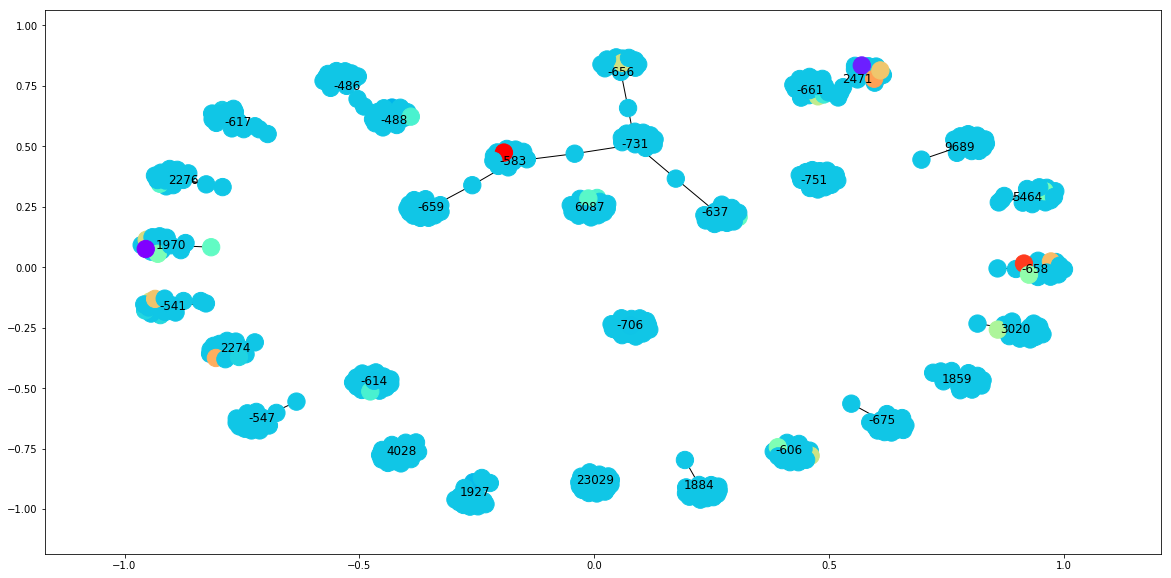

In [28]:
G = nx.Graph()
graph_root_dois = citing_movers.index[:30].values
G.add_nodes_from(graph_root_dois)
G.add_edges_from(flatten(
    [
        [cited_doi, citing_doi]
        for citing_doi in citing_dois_map.get(cited_doi, [])[:15]
    ] for cited_doi in graph_root_dois
))
all_nodes = nx.nodes(G)
labels = {
    doi: change
    for doi, change in zip(graph_root_dois, all_movers['change'][graph_root_dois])
}
node_colors = [
    pchange if not pd.isnull(pchange) else 0
    for pchange in all_movers['change'][list(all_nodes)]
]
# print(node_colors)
plt.rc('figure', figsize=(20.0, 10.0))
pos = nx.spring_layout(G)
nx.draw_networkx(
    G, pos=pos, arrows=True, with_labels=True, font_weight='normal',
    labels=labels, node_color=node_colors,
    cmap=plt.get_cmap('rainbow'),
    vmin=min(node_colors),
    vmax=max(node_colors)
)
plt.rc('figure', figsize=(6, 5))


In [29]:
# The above network chart is a bit crowded and static, show a dynamic chart instead...

tooltips=[
    ("doi", "@doi"),
    ("change", "@change"),
    ("incoming", "@incoming"),
    ("title", "@title")
]

all_node_dois = list(all_nodes)

plot = Plot(
    plot_width=800, plot_height=600,
    x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1)
)

plot.add_tools(HoverTool(tooltips=tooltips), WheelZoomTool(), PanTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0,0))
graph_renderer.node_renderer.data_source.add(all_node_dois, 'doi')
graph_renderer.node_renderer.data_source.add(all_movers['change'][all_node_dois], 'change')
graph_renderer.node_renderer.data_source.add(all_movers['incoming'][all_node_dois], 'incoming')
graph_renderer.node_renderer.data_source.add(all_movers['title'][all_node_dois], 'title')

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=2)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=4)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=4)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = NodesOnly()

plot.renderers.append(graph_renderer)

show(plot, notebook_handle=True)

This still looks a bit crowded.

TODO:

* add more useful information
* display deeper relationships

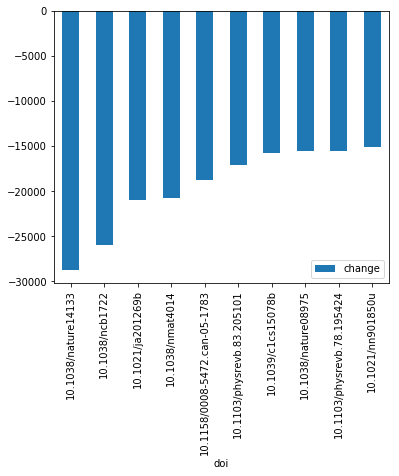

In [30]:
top_movers_1000_plus[:10][['title', 'change']].plot(kind='bar')

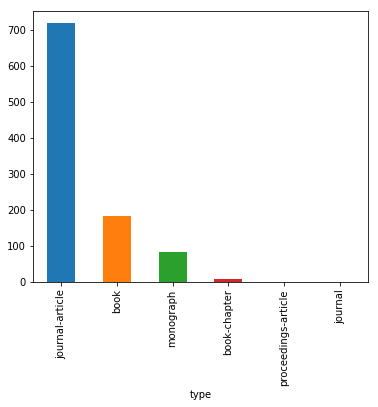

In [31]:
df[:1000].groupby('type').size().sort_values(ascending=False).plot(kind='bar')

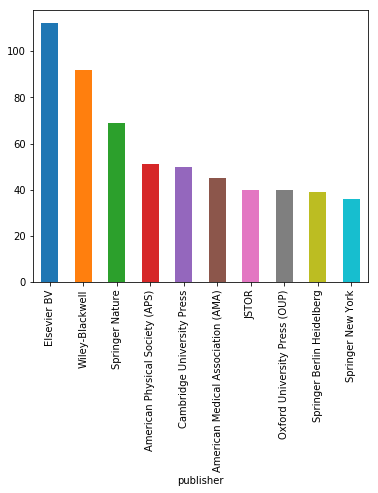

In [32]:
df[:1000].groupby('publisher').size().sort_values(ascending=False)[:10].plot(kind='bar')

In [33]:
df.head()

,incoming,outgoing,pagerank,title,reference_count,referenced_by_count,created,type,publisher,container_title,author_count,fist_subject_area,subject_areas,provenance,created_dt,first_subject_area,position_by_pagerank
doi,,,,,,,,,,,,,,,,,
10.1038/227680a0,35500,3,154.13618,Cleavage of Structural Proteins during the Ass...,22.0,129131.0,2005-08-01T18:25:18Z,journal-article,Springer Nature,Nature,1.0,NaN,Multidisciplinary,crossref-works-page-92943-offset-92943000.json,2005-08-01 18:25:18,Multidisciplinary,0
10.1016/0003-2697(76)90527-3,34913,0,149.18823,A rapid and sensitive method for the quantitat...,24.0,113788.0,2004-12-08T18:24:04Z,journal-article,Elsevier BV,Analytical Biochemistry,1.0,NaN,Biophysics|Cell Biology|Biochemistry|Molecular...,crossref-works-page-93069-offset-93069000.json,2004-12-08 18:24:04,Biophysics,1
10.1107/s0108767307043930,26464,0,145.72604,A short history ofSHELX,60.0,52231.0,2007-12-21T14:12:50Z,journal-article,International Union of Crystallography (IUCr),Acta Crystallographica Section A Foundations o...,1.0,NaN,NaN,crossref-works-page-93063-offset-93063000.json,2007-12-21 14:12:50,None,2
10.1006/meth.2001.1262,23043,0,123.47473,Analysis of Relative Gene Expression Data Usin...,11.0,45463.0,2002-10-06T19:30:44Z,journal-article,Elsevier BV,Methods,2.0,NaN,"General Biochemistry, Genetics and Molecular B...",crossref-works-page-93065-offset-93065000.json,2002-10-06 19:30:44,"General Biochemistry, Genetics and Molecular B...",3
10.1006/abio.1976.9999,7063,0,110.61359,A Rapid and Sensitive Method for the Quantitat...,0.0,10938.0,2003-01-09T12:12:55Z,journal-article,Elsevier BV,Analytical Biochemistry,1.0,NaN,Biophysics|Cell Biology|Biochemistry|Molecular...,crossref-works-page-90347-offset-90347000.json,2003-01-09 12:12:55,Biophysics,4


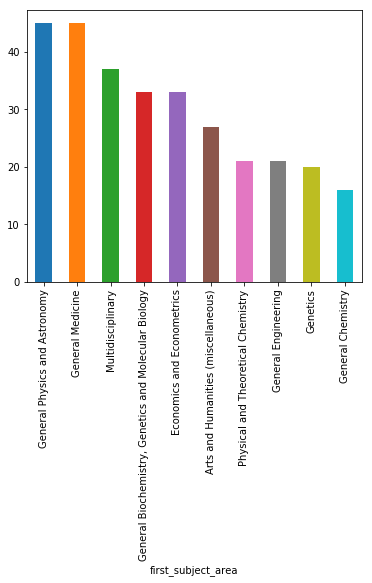

In [34]:
df[:1000].groupby('first_subject_area').size().sort_values(ascending=False)[:10].plot(kind='bar')

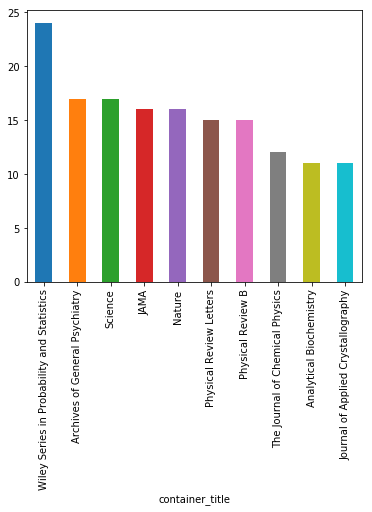

In [35]:
df[:1000].groupby('container_title').size().sort_values(ascending=False)[:10].plot(kind='bar')

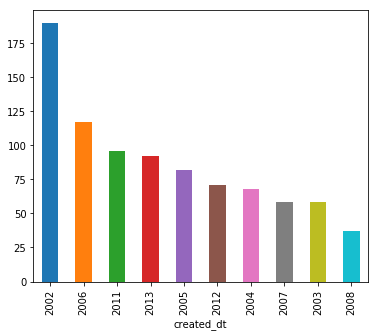

In [36]:
df[:1000].groupby(df['created_dt'].dt.to_period("Y")).size().sort_values(ascending=False)[:10].plot(kind='bar')